In [220]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('..')

In [3]:
from drone_sar.ipsar_dataset import IPSARDataset
from drone_sar.lightning_detector import get_lightning_trainer, LightningDetector
from collections import Counter

In [4]:
train_data = IPSARDataset("../heridal/trainImages/")
test_data = IPSARDataset("../heridal/testImages")
item = test_data[0]

In [5]:
trainer = get_lightning_trainer("IPSAR-DETR-FIXED", max_epochs=1000)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [123]:
# best_model_path = "/home/iz/workspace/DroneSearchAndRescue/notebooks/.checkpoints/epoch=88-step=14151.ckpt"
best_model_path = "/home/iz/workspace/DroneSearchAndRescue/notebooks/.checkpoints/epoch=65-step=10494.ckpt"

In [124]:
best_model = LightningDetector.load_from_checkpoint(best_model_path, lr=0.01)

/home/iz/.cache/pypoetry/virtualenvs/drone-sar-xLdq85T6-py3.10/lib/python3.10/site-packages/transformers/models/detr/image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [125]:
test_dl_b1 = test_data.get_dataloader(best_model.processor, bs=1, shuffle=False)
train_dl_b1 = train_data.get_dataloader(best_model.processor, bs=1, shuffle=False)

In [126]:
best_val_outputs = trainer.predict(best_model, test_dl_b1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/iz/.cache/pypoetry/virtualenvs/drone-sar-xLdq85T6-py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

In [128]:
best_train_outputs = trainer.predict(best_model, train_dl_b1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

In [221]:
best_train_outputs[0].keys()

odict_keys(['loss', 'loss_dict', 'logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])

In [212]:
# best_train_outputs[0]["last_hidden_state"]

In [177]:
import pandas as pd

In [191]:
# dict(best_train_outputs[0])

In [281]:
post_procesed_out = [best_model.processor.post_process_object_detection(
    o,
    threshold=0.5,
    target_sizes=[target_item["target_sizes"][::-1]]
) for o in best_train_outputs]

In [284]:
post_procesed_out[2]

[{'scores': tensor([0.5015, 0.9644, 0.7982, 0.9550]),
  'labels': tensor([0, 0, 0, 0]),
  'boxes': tensor([[2497.3184,  733.9232, 2555.3699,  769.3301],
          [2479.5378,  697.2735, 2541.7234,  761.1852],
          [3734.9309, 2020.8832, 3804.5334, 2075.6953],
          [2393.9370, 1803.6348, 2453.4878, 1854.1315]])}]

In [224]:
train_df = pd.DataFrame([{**dict(outputs), **item} for outputs, item in zip(best_train_outputs, train_data)])
train_df["split"] = "train"
val_df = pd.DataFrame([{**dict(outputs), **item} for outputs, item in zip(best_val_outputs, test_data)])
val_df["split"] = "val"
pred_df = pd.concat([train_df, val_df])

In [225]:
pred_df.head(1)

,loss,loss_dict,logits,pred_boxes,last_hidden_state,encoder_last_hidden_state,img_path,pil,target_sizes,boxes,class_labels,split
0,tensor(0.0008),"{'loss_ce': tensor(0.0008), 'loss_bbox': tenso...","[[[tensor(-3.7433), tensor(3.6604)], [tensor(-...","[[[tensor(0.0026), tensor(0.6534), tensor(0.01...","[[[tensor(0.0731), tensor(-0.6691), tensor(-0....","[[[tensor(-0.0368), tensor(-0.0340), tensor(-0...",../heridal/trainImages/train_VRD_0080.JPG,<PIL.MpoImagePlugin.MpoImageFile image mode=RG...,"(4000, 3000)",[],[],train


In [259]:
pred_df["loss"].apply(lambda x: x.item()).values

In [268]:
vals = pred_df["pred_boxes"].apply(lambda x: len(x[0])).values

In [275]:
pred_df["pred_boxes"].iloc[0].shape

torch.Size([1, 100, 4])

In [272]:
# vals

In [269]:
import matplotlib.pyplot as plt

<BarContainer object of 1684 artists>

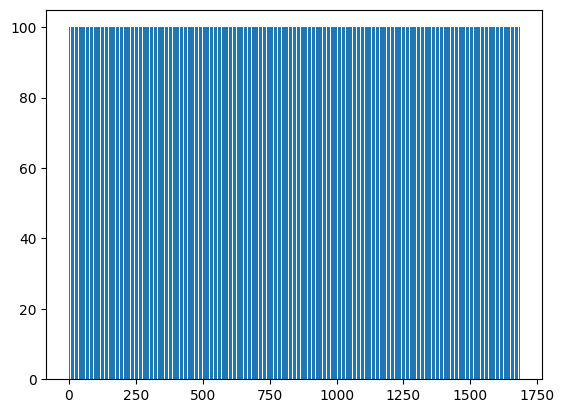

In [270]:
plt.bar(range(len(vals)), vals)

In [243]:
outputs = best_train_outputs
target_ds = train_data

# outputs = best_val_outputs
# target_ds = test_data

In [254]:
train_data[0]

{'img_path': '../heridal/trainImages/train_VRD_0080.JPG',
 'pil': <PIL.MpoImagePlugin.MpoImageFile image mode=RGB size=4000x3000>,
 'target_sizes': (4000, 3000),
 'boxes': tensor([], size=(0, 4)),
 'class_labels': tensor([], dtype=torch.int64)}

In [246]:
# max(enumerate(target_ds), key=lambda x: len(x[1]["boxes"]))

In [247]:
import numpy as np

In [248]:
loss_sort_index = np.argsort([o["loss"] for o in outputs])
sorted_outputs = np.array(outputs)[loss_sort_index]
sorted_ds = np.array(list(target_ds))[loss_sort_index]

In [240]:
id = 366
target_output = sorted_outputs[id]
target_item = sorted_ds[id]
post_procesed_out = best_model.processor.post_process_object_detection(
    target_output,
    threshold=0.5,
    target_sizes=[target_item["target_sizes"][::-1]]
)[0]

X0, Y0, X1, Y1 = post_procesed_out["boxes"].T
W, H = X1 - X0, Y1 - Y0 
post_procesed_out["boxes"][:, 2] = W + 40
post_procesed_out["boxes"][:, 3] = H + 40

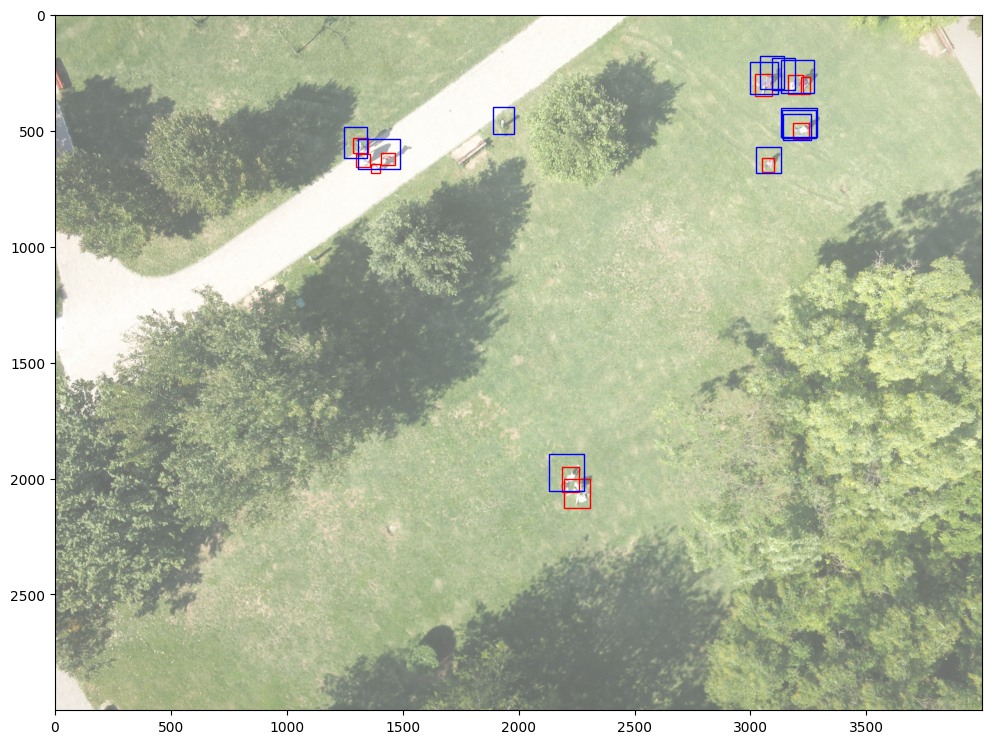

In [241]:
from drone_sar.vis import plt_show

plt_show(
    target_item["pil"],
    im_opacity=0.6,
    colored_boxes_dict={"red": target_item["boxes"], "blue": post_procesed_out["boxes"]}
)